<a href="https://colab.research.google.com/github/JimKing100/Jestimate/blob/master/Latest7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Installs
%%capture
!pip install category_encoders==2.0.0

In [0]:
# Import libraries
import pandas as pd
import numpy as np
import math

import pandas_profiling

from datetime import datetime

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report

import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from geopy.distance import vincenty as get_geodesic_distance

In [305]:
# Load SF real estate data - 10 years (2009-2018) of single family home sales in San Francisco downloaded from the SF MLS
# Longitude and latitude were added to the csv file prior to loading using geocoding.geo.census.gov 
df = pd.read_csv('https://raw.githubusercontent.com/JimKing100/Jestimate/master/data/SF-SFR-Sales-Final2d.csv')

# Rename subdistr_desc to neighborhood
df = df.rename(columns={'subdist_no': 'nid', 'subdist_desc': 'neighborhood'})

# Fill house square foot zero values with the average house square footage by bedroom for all single family homes in SF
# averagesf_data = df.groupby('beds').sf.mean()

# # Use average sf by bedroom for each 0 value in each bedroom group up to 9 bedrooms
# for i in range(0, 9): 
#   df.loc[(df['sf'] == 0) & (df['beds'] == i), 'sf'] = averagesf_data.loc[i]

# # Use 10,000sf for anything over 9 bedrooms
# df.loc[df['sf'] == 0, 'sf'] = 10000
# df = df.astype({'sf': int})

# Create subset with outliers removed - 1.6% of the data, and zero square foot homes removed - 16.2% of the data
mask = (
  (df['baths'] < 6) &
  (df['beds'] < 7) &
  (df['beds'] > 0) &
  (df['lot_sf'] < 10000) &
  (df['rooms'] < 13) &
  (df['sale_price'] < 10000000) &
  (df['sf'] < 10000) &
  (df['sf'] > 100)
)
df = df[mask]

# Check the data
print(df.shape)
df.head()

(19497, 39)


,longitude,latitude,elevation,full_address,city,state,street_no,street_name,street_suffix,zip,area,district_no,district_desc,nid,neighborhood,on_market_date,cdom,orig_list_price,sale_date,sale_price,rooms,baths,beds,sf_source,sf_source_decs,sf,lot_acres,lot_sf,year_built,zoning,lot_desc,drive_side,parking,park_leased,num_parking,shopping,transportation,type,views
0,-122.50965,37.780280,200.83,"2645 El Camino Del Mar, San Francisco, CA 94121",San Francisco,CA,2645,El Camino Del Mar,NaN,94121,1050,1,SF District 1,1050,1 - Outer Richmond,3/14/13,4,1095000,3/22/13,1260000,8,3.5,4,T,Per Tax Records,2691,NaN,0,1969,RH2,"RGLR,FNCD","PVDW,PVSW","ATCH,GARG",0,2,4BLK,1BLK,3STR,"PNRM,OCEN,PARK,GRDN"
1,-122.50929,37.762608,23.21,"1278 La Playa St, San Francisco, CA 94122",San Francisco,CA,1278,La Playa,St,94122,2030,2,SF District 2,2030,2 - Outer Sunset,12/3/15,144,1250000,4/25/16,1075000,9,3.0,4,T,Per Tax Records,2437,0.0689,3000,1947,RM1,RGLR,0,"ATCH,GARG,ATDR,INAC",ONST,1,2BLK,1BLK,0,0
2,-122.50929,37.762608,23.21,"1278 La Playa St, San Francisco, CA 94122",San Francisco,CA,1278,La Playa,St,94122,2030,2,SF District 2,2030,2 - Outer Sunset,5/18/17,36,1395000,8/17/17,1525000,9,5.0,5,D,Per Architect,2597,0.0689,3000,1947,RM1,RGLR,0,"ATCH,GARG,ATDR,INAC",ONST,1,2BLK,1BLK,0,0
3,-122.50924,37.777330,189.11,"590 48th Ave, San Francisco, CA 94121",San Francisco,CA,590,48th,Ave,94121,1050,1,SF District 1,1050,1 - Outer Richmond,6/27/10,42,725000,8/20/10,715000,5,1.0,2,T,Per Tax Records,1312,NaN,0,1939,RH1,RGLR,"PVDW,PVSW",GARG,0,2,3BLK,1BLK,"ATAC,2STR,FIXR","WATR,OCEN,PARK"
4,-122.50919,37.776695,175.89,"618 48th Ave, San Francisco, CA 94121",San Francisco,CA,618,48th,Ave,94121,1050,1,SF District 1,1050,1 - Outer Richmond,6/7/12,24,1595000,7/13/12,1595000,8,4.0,4,T,Per Tax Records,3307,NaN,0,1951,NaN,RGLR,PVDW,"ATCH,GARG,ATDR,INAC",0,3,4BLK,2BLK,3STR,"PNRM,CTYL,OCEN,PARK"


In [0]:
#pandas_profiling.ProfileReport(df)

In [307]:
# Train, test split on date of 01/01/2018
df['sale_date'] = pd.to_datetime(df['sale_date'], infer_datetime_format=True)
df['year_sold'] = df['sale_date'].dt.year
df['month_sold'] = df['sale_date'].dt.month
df['day_sold'] = df['sale_date'].dt.day

df['on_market_date'] = pd.to_datetime(df['on_market_date'], infer_datetime_format=True)
df['year_on_market'] = df['on_market_date'].dt.year
df['month_on_market'] = df['on_market_date'].dt.month
df['day_on_market'] = df['on_market_date'].dt.day

low_cutoff = 2008
high_cutoff = 2018
train = df[(df['year_sold'] >= low_cutoff) & (df['year_sold'] < high_cutoff)]
test  = df[df['year_sold'] >= high_cutoff]
print(train.shape)
print(test.shape)

(17618, 45)
(1879, 45)


In [0]:
# Create a copy of full_address to add back to the final dataframe for display
test_addr = pd.DataFrame(test, columns = ['full_address', 'neighborhood'])
test_addr = test_addr.reset_index()

In [309]:
# Create a baseline
sale_price_mean = test['sale_price'].mean()

y_actual = np.array(test['sale_price'])
y_pred = [sale_price_mean] * len(y_actual)
mae = mean_absolute_error(y_actual, y_pred)
print('Baseline MAE = ', mae)

Baseline MAE =  684458.2666292042


In [0]:
# Wrangle the data for train and test
def engineer_features(X):
  
  # Impute mean for null long/lat/elev based on mean of of neighborhood
  def feature_calc(feature, nid, f_dict):
    if math.isnan(feature):
      if (nid) in f_dict:
        new_feature = f_dict[nid]
        return new_feature
    else:
      return feature
    
    return feature
  
  temp = X[~X['longitude'].isna()].groupby(['nid'])['longitude'].mean()
  long_dict = dict(temp)
  X['longitude'] = X.apply(lambda x: feature_calc(x['longitude'], x['nid'], long_dict), axis=1)
  
  temp = X[~X['latitude'].isna()].groupby(['nid'])['latitude'].mean()
  lat_dict = dict(temp)
  X['latitude'] = X.apply(lambda x: feature_calc(x['latitude'], x['nid'], lat_dict), axis=1)
  
  temp = X[~X['elevation'].isna()].groupby(['nid'])['elevation'].mean()
  elev_dict = dict(temp)
  X['elevation'] = X.apply(lambda x: feature_calc(x['elevation'], x['nid'], elev_dict), axis=1)
  
  X['zip'] = X['zip'].astype(int)
  
  # Fill rooms zero values by adding beds and baths
  def room_calc(rooms_val, beds_val, baths_val):
    if rooms_val == 0:
      total = beds_val + baths_val
    else:
      total = rooms_val
      
    return total
  
  X['rooms'] = X.apply(lambda x: room_calc(x['rooms'], x['beds'], x['baths']), axis=1)
  
  # Fill baths zero values by adding beds and baths
  X.loc[(X['baths'] == 0), 'baths'] = 1
  
  # Fill lot_sf zero values by using lot_acres to calc
  def lotsf_calc(lotsf_val, lotacres_val):
    if lotsf_val == 0:
      total = lotacres_val * 43560
    else:
      total = lotsf_val
      
    return total
  
  X['lot_sf'] = X.apply(lambda x: lotsf_calc(x['lot_sf'], x['lot_acres']), axis=1)
  
  # Fill lot_acres zero values by using lot_sf to calc
  def lotacres_calc(lotacres_val, lotsf_val):
    if lotacres_val == 0:
      total = lotsf_val / 43560
    else:
      total = lotacres_val
      
    return total
  
  X['lot_acres'] = X.apply(lambda x: lotacres_calc(x['lot_acres'], x['lot_sf']), axis=1)
  
  X['ds_count'] = X.apply(lambda x: (x['drive_side'].count(',') + 1), axis=1)
  X['parking_count'] = X.apply(lambda x: (x['parking'].count(',') + 1), axis=1)
  X['view_count'] = X.apply(lambda x: (x['views'].count(',') + 1), axis=1)
  
  # Engineer new feature mean_neighbor_price THIS TAKES 1.5 HOURS TO RUN
  # Output was saved to nhoods files and is loaded later to save time
  nhoods = X[['sf', 'longitude', 'latitude']]
  
  def neighbor_mean(sqft, source_latitude, source_longitude):
    
    source_latlong = source_latitude, source_longitude
    source_table = train[(train['sf'] >= (sqft * .85)) & (train['sf'] <= (sqft * 1.15))]
    target_table = pd.DataFrame(source_table, columns = ['sf', 'latitude', 'longitude', 'year_sold', 'sale_price']) 

    def get_distance(row):
        target_latlong = row['latitude'], row['longitude']
        return get_geodesic_distance(target_latlong, source_latlong).meters

    target_table['distance'] = target_table.apply(get_distance, axis=1)

    # Get the nearest 3 locations
    nearest_target_table = target_table.sort_values(['year_sold', 'distance'], ascending=[False, True])[1:4]
    
    new_mean = nearest_target_table['sale_price'].mean() / nearest_target_table['sf'].mean()
    if math.isnan(new_mean):
      new_mean = test['sale_price'].mean() / test['sf'].mean()

    return new_mean
  
  # This is commented out for time reasons (see above)
  # nhoods['mean_hood_ppsf'] = X.apply(lambda x: neighbor_mean(x['sf'], x['latitude'], x['longitude']), axis=1)
  # nhoods = nhoods.reset_index()
  # nhoods = nhoods.rename(columns={'index': 'old_index'})
  # nhoods.to_csv('/content/nhoods.csv')
  
  # Drop unneeded columns
  unneeded_columns = ['sale_date', 'on_market_date', 'city', 'state', 'street_no', 'street_suffix',
                      'day_on_market', 'month_on_market', 'year_on_market', 'month_sold', 'day_sold', 'orig_list_price', 'cdom',
                      'sf_source', 'area', 'sf_source_decs', 'lot_acres', 'views', 'parking', 'full_address', 'zoning',
                      'district_no', 'district_desc', 'lot_desc', 'drive_side', 'parking_count', 'num_parking',
                      'neighborhood', 'shopping', 'transportation', 'type']
  X = X.drop(columns=unneeded_columns)
  
  return X

pd.set_option('mode.chained_assignment', None)
train = engineer_features(train)
test = engineer_features(test)

In [0]:
# Load the nhoods data created in the wrangle function - this is the comparable sale price per square foot
rnhoods = pd.read_csv('https://raw.githubusercontent.com/JimKing100/Jestimate/master/data/nhoods-train5.csv')
tnhoods = pd.read_csv('https://raw.githubusercontent.com/JimKing100/Jestimate/master/data/nhoods-test5.csv')
train = pd.merge(train, rnhoods[['old_index', 'mean_hood_ppsf']], left_index=True, right_on='old_index')
test = pd.merge(test, tnhoods[['old_index', 'mean_hood_ppsf']], left_index=True, right_on='old_index')
train = train.drop(columns=['old_index'])
test = test.drop(columns=['old_index'])
train = train.rename(columns={'mean_hood_ppsf': 'comp_price_sf'})
test = test.rename(columns={'mean_hood_ppsf': 'comp_price_sf'})

In [312]:
print(train.shape)
train.head()

(17618, 18)


,longitude,latitude,elevation,street_name,zip,nid,sale_price,rooms,baths,beds,sf,lot_sf,year_built,park_leased,year_sold,ds_count,view_count,comp_price_sf
0,-122.50965,37.780280,200.83,El Camino Del Mar,94121,1050,1260000,8.0,3.5,4,2691,NaN,1969,0,2013,2,4,708.044205
1,-122.50929,37.762608,23.21,La Playa,94122,2030,1075000,9.0,3.0,4,2437,3000.0,1947,ONST,2016,1,1,720.555967
2,-122.50929,37.762608,23.21,La Playa,94122,2030,1525000,9.0,5.0,5,2597,3000.0,1947,ONST,2017,1,1,707.338594
3,-122.50924,37.777330,189.11,48th,94121,1050,715000,5.0,1.0,2,1312,NaN,1939,0,2010,2,3,1004.622077
4,-122.50919,37.776695,175.89,48th,94121,1050,1595000,8.0,4.0,4,3307,NaN,1951,0,2012,1,4,683.085603


In [313]:
print(test.shape)
test.head()

(1879, 18)


,longitude,latitude,elevation,street_name,zip,nid,sale_price,rooms,baths,beds,sf,lot_sf,year_built,park_leased,year_sold,ds_count,view_count,comp_price_sf
0,-122.509190,37.776695,175.89,48th,94121,1050,3310000,8.0,4.0,4,3735,3959.0,1951,ONST,2018,1,8,965.439584
1,-122.509056,37.758010,23.01,Great Highway,94122,2030,1830000,7.0,3.0,4,2120,3072.0,1948,ONST,2018,1,1,687.781430
2,-122.509020,37.758636,22.70,La Playa,94122,2030,1300000,3.0,1.0,2,1087,1245.0,1944,ONST,2018,2,1,851.259259
3,-122.508980,37.773680,40.08,48th,94121,1050,1300000,6.0,1.5,2,1326,2696.0,1942,ONST,2018,2,1,1033.491627
4,-122.508270,37.778465,225.66,47th,94121,1050,1865000,6.0,2.0,3,1800,3000.0,1931,ONST,2018,2,1,909.818563


In [0]:
# Create the comparable sales price using comp_price_sf * sf
train['comp_price_sf'] = train['comp_price_sf'] * train['sf']
test['comp_price_sf'] = test['comp_price_sf'] * test['sf']
train['comp_price_sf'] = train['comp_price_sf'].astype(int)
test['comp_price_sf'] = test['comp_price_sf'].astype(int)

In [315]:
print(train.shape)
train.head()

(17618, 18)


,longitude,latitude,elevation,street_name,zip,nid,sale_price,rooms,baths,beds,sf,lot_sf,year_built,park_leased,year_sold,ds_count,view_count,comp_price_sf
0,-122.50965,37.780280,200.83,El Camino Del Mar,94121,1050,1260000,8.0,3.5,4,2691,NaN,1969,0,2013,2,4,1905346
1,-122.50929,37.762608,23.21,La Playa,94122,2030,1075000,9.0,3.0,4,2437,3000.0,1947,ONST,2016,1,1,1755994
2,-122.50929,37.762608,23.21,La Playa,94122,2030,1525000,9.0,5.0,5,2597,3000.0,1947,ONST,2017,1,1,1836958
3,-122.50924,37.777330,189.11,48th,94121,1050,715000,5.0,1.0,2,1312,NaN,1939,0,2010,2,3,1318064
4,-122.50919,37.776695,175.89,48th,94121,1050,1595000,8.0,4.0,4,3307,NaN,1951,0,2012,1,4,2258964


In [316]:
print(test.shape)
test.head()

(1879, 18)


,longitude,latitude,elevation,street_name,zip,nid,sale_price,rooms,baths,beds,sf,lot_sf,year_built,park_leased,year_sold,ds_count,view_count,comp_price_sf
0,-122.509190,37.776695,175.89,48th,94121,1050,3310000,8.0,4.0,4,3735,3959.0,1951,ONST,2018,1,8,3605916
1,-122.509056,37.758010,23.01,Great Highway,94122,2030,1830000,7.0,3.0,4,2120,3072.0,1948,ONST,2018,1,1,1458096
2,-122.509020,37.758636,22.70,La Playa,94122,2030,1300000,3.0,1.0,2,1087,1245.0,1944,ONST,2018,2,1,925318
3,-122.508980,37.773680,40.08,48th,94121,1050,1300000,6.0,1.5,2,1326,2696.0,1942,ONST,2018,2,1,1370409
4,-122.508270,37.778465,225.66,47th,94121,1050,1865000,6.0,2.0,3,1800,3000.0,1931,ONST,2018,2,1,1637673


In [0]:
#pandas_profiling.ProfileReport(train)

In [318]:
# Split train into train and validation
cutoff = 2017
temp=train.copy()
train = temp[temp['year_sold'] < 2017]
val  = temp[temp['year_sold'] >= 2017]
print(train.shape, val.shape, test.shape)

(15686, 18) (1932, 18) (1879, 18)


In [319]:
# Encode and fit a linear regression model
target = 'sale_price'

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
  ce.OrdinalEncoder(),
  SimpleImputer(strategy='mean'),
  LinearRegression()
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

# Print regression metrics for validation 
val_mse = mean_squared_error(y_val, y_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_pred)
val_r2 = r2_score(y_val, y_pred)
print('Validation Mean Absolute Error:', val_mae)
print('Validation R^2:', val_r2)
print('\n')

ty_pred = pipeline.predict(X_test)

# Print regression metrics for test
test_mse = mean_squared_error(y_test, ty_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, ty_pred)
test_r2 = r2_score(y_test, ty_pred)
print('Test Mean Absolute Error:', test_mae)
print('Test R^2:', test_r2)

Validation Mean Absolute Error: 249452.30836480067
Validation R^2: 0.8364321792383549


Test Mean Absolute Error: 276308.0221742051
Test R^2: 0.7981539712827466


In [320]:
# Add the prediction, difference and address to the final dataframe
final = test.copy()
final = final.reset_index()
final['prediction'] = ty_pred
final['difference'] = final['prediction'] - final['sale_price']
final['prediction'] = final['prediction'].astype(int)
final['difference'] = final['difference'].astype(int)
final['full_address'] = test_addr['full_address']
final['neighborhood'] = test_addr['neighborhood']
print(final.shape)
final.head()

(1879, 23)


,index,longitude,latitude,elevation,street_name,zip,nid,sale_price,rooms,baths,beds,sf,lot_sf,year_built,park_leased,year_sold,ds_count,view_count,comp_price_sf,prediction,difference,full_address,neighborhood
0,0,-122.509190,37.776695,175.89,48th,94121,1050,3310000,8.0,4.0,4,3735,3959.0,1951,ONST,2018,1,8,3605916,3306051,-3948,"618 48th Ave, San Francisco, CA 94121-2410",1 - Outer Richmond
1,1,-122.509056,37.758010,23.01,Great Highway,94122,2030,1830000,7.0,3.0,4,2120,3072.0,1948,ONST,2018,1,1,1458096,1614575,-215424,"1516 Great Highway, San Francisco, CA 94122",2 - Outer Sunset
2,2,-122.509020,37.758636,22.70,La Playa,94122,2030,1300000,3.0,1.0,2,1087,1245.0,1944,ONST,2018,2,1,925318,1090913,-209086,"1492 La Playa St, San Francisco, CA 94122",2 - Outer Sunset
3,3,-122.508980,37.773680,40.08,48th,94121,1050,1300000,6.0,1.5,2,1326,2696.0,1942,ONST,2018,2,1,1370409,1493652,193652,"784 48th Ave, San Francisco, CA 94121",1 - Outer Richmond
4,4,-122.508270,37.778465,225.66,47th,94121,1050,1865000,6.0,2.0,3,1800,3000.0,1931,ONST,2018,2,1,1637673,1732993,-132006,"525 47th Ave, San Francisco, CA 94121",1 - Outer Richmond


In [321]:
# Calculate the metrics used by Zillow
final['pred_percent'] = final['difference']/final['prediction']
pred_median_error = final['pred_percent'].median()
pred_five_percent = (final['pred_percent'][(final['pred_percent'] >= -.05) &
                                           (final['pred_percent'] <= .05)].count())/final.shape[0]

pred_ten_percent = (final['pred_percent'][(final['pred_percent'] >= -.10) &
                                          (final['pred_percent'] <= .10)].count())/final.shape[0]

pred_twenty_percent = (final['pred_percent'][(final['pred_percent'] >= -.20) &
                                             (final['pred_percent'] <= .20)].count())/final.shape[0]

print('Median Error - %.4f%%' % (pred_median_error * 100))
print('Prediction Within 5 percent - %.4f%%' % (pred_five_percent * 100))
print('Prediction Within 10 percent - %.4f%%' % (pred_ten_percent * 100))
print('Prediction Within 20 percent - %.4f%%' % (pred_twenty_percent * 100))

Median Error - -1.6698%
Prediction Within 5 percent - 21.2879%
Prediction Within 10 percent - 43.4806%
Prediction Within 20 percent - 75.4657%


In [326]:
final.sort_values(by=['pred_percent']).head(50)

,index,longitude,latitude,elevation,street_name,zip,nid,sale_price,rooms,baths,beds,sf,lot_sf,year_built,park_leased,year_sold,ds_count,view_count,comp_price_sf,prediction,difference,full_address,neighborhood,pred_percent
1334,1334,-122.430360,37.759003,249.54,Sanchez,94114,5100,2500000,3.0,1.0,2,600,NaN,0,ONST,2018,1,1,749556,1110966,-1389033,"617 Sanchez St, San Francisco, CA 94114",5 - Eureka Valley/Dolore,-1.250293
1355,1355,-122.429370,37.739647,298.02,Laidley,94131,5010,9700000,10.5,5.5,5,5320,4996.0,1957,ONST,2018,1,4,5500989,4457780,-5242219,"143 Laidley St, San Francisco, CA 94131",5 - Glen Park,-1.175971
199,199,-122.492590,37.784786,202.68,32nd,94121,1060,3750000,8.0,2.0,4,2991,3600.0,1911,ONST,2018,1,1,1782155,1873440,-1876559,"224 32nd Ave, San Francisco, CA 94121",1 - Sea Cliff,-1.001665
1335,1335,-122.430300,37.758327,257.38,Sanchez,94114,5100,4700000,6.0,3.0,3,2337,2625.0,1912,ONST,2018,1,5,2498241,2382650,-2317349,"677 Sanchez St, San Francisco, CA 94114",5 - Eureka Valley/Dolore,-0.972593
814,814,-122.453804,37.790640,203.01,Pacific,94118,7030,8750000,11.0,4.0,5,4264,4181.0,1951,ONST,2018,1,1,5644322,4531224,-4218775,"3577 Pacific Ave, San Francisco, CA 94118",7 - Presidio Heights,-0.931045
1030,1030,-122.443660,37.794132,211.26,Vallejo,94123,7020,8000000,8.0,3.5,3,3526,3436.0,1925,ONST,2018,1,4,5363907,4409179,-3590820,"2811 Vallejo St, San Francisco, CA 94123",7 - Pacific Heights,-0.814397
689,689,-122.461860,37.761670,349.47,5th,94122,2060,3125000,9.0,3.0,4,2920,3000.0,1910,ONST,2018,1,1,1662187,1747747,-1377252,"1435 5th Ave, San Francisco, CA 94122",2 - Inner Sunset,-0.788016
564,564,-122.467700,37.783882,179.18,9th,94118,1020,3700000,8.0,2.0,3,2400,3000.0,1910,ONST,2018,1,1,2233733,2120181,-1579818,"240 9th Ave, San Francisco, CA 94118",1 - Inner Richmond,-0.745134
651,651,-122.463715,37.787920,201.77,5th,94118,1040,4425000,9.0,3.0,4,3120,3598.0,1907,ONST,2018,1,1,2739114,2551976,-1873023,"37 5th Ave, San Francisco, CA 94118",1 - Lake Street,-0.733950
1146,1146,-122.438180,37.736763,309.19,Sussex,94131,5010,3855000,7.0,3.5,5,3200,4177.0,1938,ONST,2018,2,3,2363866,2264837,-1590162,"300 Sussex St, San Francisco, CA 94131",5 - Glen Park,-0.702109


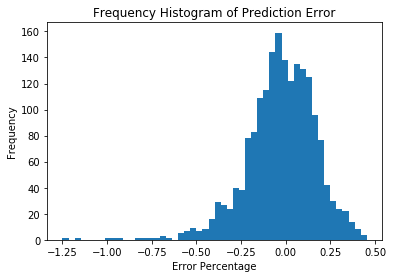

In [323]:
%matplotlib inline
plt.hist(final['pred_percent'], bins=50)
plt.gca().set(title='Frequency Histogram of Prediction Error', xlabel='Error Percentage', ylabel='Frequency');

In [324]:
data = final[['full_address', 'neighborhood', 'nid', 'sale_price', 'prediction', 'difference']]
print(data.shape)
data.head()

(1879, 6)


,full_address,neighborhood,nid,sale_price,prediction,difference
0,"618 48th Ave, San Francisco, CA 94121-2410",1 - Outer Richmond,1050,3310000,3306051,-3948
1,"1516 Great Highway, San Francisco, CA 94122",2 - Outer Sunset,2030,1830000,1614575,-215424
2,"1492 La Playa St, San Francisco, CA 94122",2 - Outer Sunset,2030,1300000,1090913,-209086
3,"784 48th Ave, San Francisco, CA 94121",1 - Outer Richmond,1050,1300000,1493652,193652
4,"525 47th Ave, San Francisco, CA 94121",1 - Outer Richmond,1050,1865000,1732993,-132006


In [0]:
# data.to_csv('/content/display_data.csv')